# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize

from keras import Input
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Lambda

from keras.callbacks import EarlyStopping

In [98]:
tf.__version__

'2.7.0'

In [99]:
tf.keras.__version__

'2.7.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

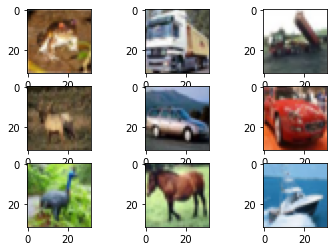

(50000, 32, 32, 3)

In [100]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from keras.datasets import cifar10
from keras.applications.vgg19 import preprocess_input

(X_train_raw, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train_full = preprocess_input(X_train_raw)
X_test = preprocess_input(X_test)

# One-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# Get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_raw[i])
plt.show()

X_train_full.shape

## Build and train the model

Build and train your model. 

In [101]:
# TODO: load the model you selected
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Scaling the original image to 160 px x 160 px
upscale = (Lambda(lambda x: resize(x, [160, 160])))(inputs)


base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=upscale,
    input_shape=(160,160,3),
    pooling=max
)

base_model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_8 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584

In [102]:
# TODO: Transfer learning - build your own model based on the selected model

x = base_model.output
x = Flatten()(x)
x = Dense(512,activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512,activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
output = Dense(units=10, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=output)


base_model.trainable = False

In [103]:
# show the structure of your model
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_8 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       1475

In [104]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_full, y_train_full, batch_size=32, epochs=20, validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)])

Epoch 1/20
1563/1563 [==============================] - 111s 70ms/step - loss: 0.6556 - accuracy: 0.7826 - val_loss: 0.2691 - val_accuracy: 0.9166
Epoch 2/20
1563/1563 [==============================] - 109s 70ms/step - loss: 0.3968 - accuracy: 0.8662 - val_loss: 0.1975 - val_accuracy: 0.9372
Epoch 3/20
1563/1563 [==============================] - 109s 70ms/step - loss: 0.3195 - accuracy: 0.8918 - val_loss: 0.1512 - val_accuracy: 0.9530
Epoch 4/20
1563/1563 [==============================] - 109s 70ms/step - loss: 0.2698 - accuracy: 0.9073 - val_loss: 0.1067 - val_accuracy: 0.9692
Epoch 5/20
1563/1563 [==============================] - 109s 70ms/step - loss: 0.2313 - accuracy: 0.9215 - val_loss: 0.0808 - val_accuracy: 0.9778
Epoch 6/20
1563/1563 [==============================] - 109s 70ms/step - loss: 0.1971 - accuracy: 0.9302 - val_loss: 0.0621 - val_accuracy: 0.9840
Epoch 7/20
1563/1563 [==============================] - 110s 70ms/step - loss: 0.1719 - accuracy: 0.9411 - val_loss: 0

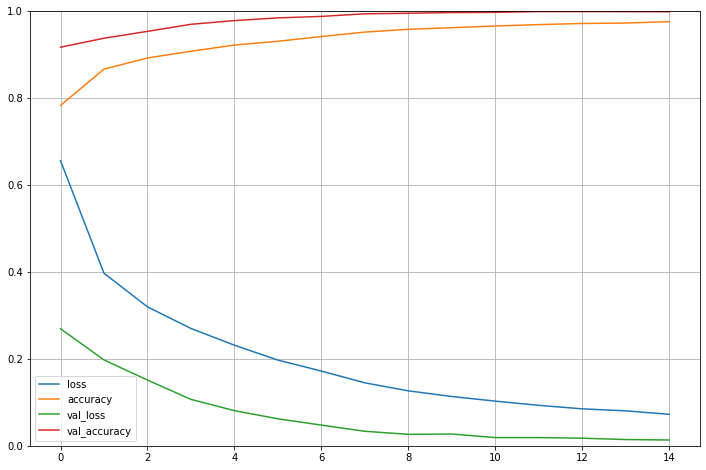

In [105]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [107]:
model.save('FDS21-M67-CIFAR10.h5') 

## Load the model and evaluate it on the test data

In [108]:
model = keras.models.load_model("FDS21-M67-CIFAR10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 18s 57ms/step - loss: 0.3891 - accuracy: 0.9016


[0.38905468583106995, 0.9016000032424927]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

This part wasn't quite as easy as the first part. We based our work on the VGG19 model, which is one of the best for image classification. We used it without the fully-connected layers on top because we trained our own.
There were quite a lot of difficulties we encountered, mostly having to do with overfitting. We started with a model that was too complex so it was learning the training data very well but it wasn't that good at generalizing. More training wasnt't improving, even with a bigger numbers of epochs.
We also tried to bypass the last convoluted layers of the VGG19 model but that wasn't much help.
Input size was also a factor. The best result was obtained by rescaling the input images to 160x160 resolution.
At first we were using Adam as an optimizer but we then switched to SGD which brought a performance improvement and allowed us to reach over 90% accuracy.
In the end we settled on a simpler model with the full VGG19 convoluted layers (frozen, so we didn't retrain them) and four fully connected layers of decreasing number of neurons and modest dropout rates inbetween and also batch normalization to help with efficiency. In total we added 6.8 million trainable parameters.
Training took around two minutes per epoch with a GTX1070ti and early stopping got it to 15 epochs out of the allowed 20 (before overfitting).